In [1]:
%pip install torch numpy datasets torchtext tqdm matplotlib huggingface_hub transformers flair scipy==1.12.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext, torchtext.vocab, torchtext.data
import tqdm
import transformers

from flair.embeddings import FlairEmbeddings

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"]) # stanford nlp dataset of binary imdb classification

print(train_data.shape)
print(train_data[0])

(25000, 2)
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few

In [4]:
seed = 4321 # seed makes results deterministic

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

np.random.seed(seed)

# tokenizer = torchtext.data.get_tokenizer("basic_english") # basic english tokenizer (uses torchtext version 0.18.0)
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
embedding_model = transformers.DistilBertModel.from_pretrained('distilbert/distilbert-base-uncased')

# set model to eval mode (no back prop)
embedding_model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [5]:
def tokenize(sample, tokenizer, max_len):
    inputs = tokenizer(sample["text"][:max_len], return_tensors="pt")
    input_ids = inputs["input_ids"].squeeze()
    attention_mask = inputs["attention_mask"].squeeze()
    return {"input_ids": input_ids, "attention_mask": attention_mask, "length": len(input_ids)}

In [6]:
max_len = 200 # max seq length is 200 as used in McCann et al.

train_data = train_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer, "max_len": max_len}
)
test_data = test_data.map(
    tokenize, fn_kwargs={"tokenizer": tokenizer, "max_len": max_len}
)

In [7]:
test_size = 0.2 # 80/20 train-test split

train_validation_data = train_data.train_test_split(test_size=test_size)
train_data = train_validation_data["train"]
validation_data = train_validation_data["test"]
print(train_data[0])

{'text': '"Dragonlord" sees Chan returning to his role of "Dragon" from "The Young Master". Not much has carried over from the first film though. "Tiger", his older brother, is nowhere to be seen; neither is the Marshall, his daughter or his son played superbly by Yuen Biao in the original film. Dragon does have the same master though - presumably all the other students have moved on to other things. (Dragon\'s laziness at training is portrayed heavily in this film, so maybe he\'s still studying!) <br /><br />Originally titled "Young Master In Love", this film sees Dragon (for the first sixty minutes at least) pursuing a villager girl in various idiotic and slapstick ways. His rival for her affection is his friend (inappropriately named "Cowboy") played comically by the longtime Chan Stunt-team member Mars. We see various scenes where their silly schemes backfire. It is one of these scenes that we (thankfully) find "Dragon" in over his head.<br /><br />This film is notorious in that it

In [9]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
import flair

flair.device = torch.device('cuda')

glove_embeddings = WordEmbeddings('glove')

In [16]:
train_data = train_data.with_format(type="torch", columns=["input_ids", "label", "length"])
validation_data = validation_data.with_format(type="torch", columns=["input_ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["input_ids", "label", "length"])
train_data[0]

{'label': tensor(1),
 'input_ids': tensor([  101,  1000,  5202, 19980,  1000,  5927,  9212,  4192,  2000,  2010,
          2535,  1997,  1000,  5202,  1000,  2013,  1000,  1996,  2402,  3040,
          1000,  1012,  2025,  2172,  2038,  3344,  2058,  2013,  1996,  2034,
          2143,  2295,  1012,  1000,  6816,  1000,  1010,  2010,  3080,  2567,
          1010,  2003,  7880,  2000,  2022,  2464,  1025,  4445,  2003, 16215,
           102]),
 'length': tensor(51)}

In [17]:
import concurrent.futures

def embed_text(text): # glove embeddings
    sentence = Sentence(text)
    glove_embeddings.embed(sentence)
    return torch.stack([token.embedding for token in sentence])

def get_dataloader(dataset, batch_size, shuffle=False):
    collate_fn = get_collate_fn()
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return dataloader
    
def get_collate_fn():
    def collate_fn(batch):
        batch_ids = [i["input_ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=tokenizer.pad_token_id, batch_first=True
        )
        batch_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in batch_ids]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor: # glove embeddings
            batch_embeddings = executor.map(embed_text, batch_tokens)
        batch_embeddings = torch.stack(list(batch_embeddings))
        outputs = embedding_model(batch_ids)
        bert_embeddings = outputs.last_hidden_state # bert embeddings
        
        batch_len = [i["length"] for i in batch]
        batch_len = torch.stack(batch_len)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "glove_embeddings": batch_embeddings, "bert_embeddings": bert_embeddings, "length": batch_len, "label": batch_label}
        return batch

    return collate_fn

In [18]:
batch_size = 512

train_dataloader = get_dataloader(train_data, batch_size, shuffle=True)
validation_dataloader = get_dataloader(validation_data, batch_size)
test_dataloader = get_dataloader(test_data, batch_size)

In [19]:
class LSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_dim,
        output_dim,
        vocab_size,
        num_layers,
        bidirectional,
        dropout,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_dim,
            num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings, length):
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embeddings, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])
        return self.linear(hidden) # [batch_size, output_dim]


In [20]:
model_glove = LSTM(
    input_size = 100,
    hidden_dim = 300,
    output_dim = len(train_data.unique("label")),
    vocab_size = tokenizer.vocab_size,
    num_layers = 2,
    bidirectional = True,
    dropout = 0.5
)

model_bert = LSTM(
    input_size = 768,
    hidden_dim = 300,
    output_dim = len(train_data.unique("label")),
    vocab_size = tokenizer.vocab_size,
    num_layers = 2,
    bidirectional = True,
    dropout = 0.5
)

In [21]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [22]:
model_glove.apply(initialize_weights)
model_bert.apply(initialize_weights)

LSTM(
  (lstm): LSTM(768, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
lr = 6e-4

optimizer_glove = optim.Adam(model_glove.parameters(), lr=lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model_glove = model_glove.to(device)
model_bert = model_bert.to(device)
criterion = criterion.to(device)

cuda


In [25]:
def run(dataloader, model, criterion, optimizer, device, embedding, is_eval=False):
    if is_eval:
        model.eval()
    else:
        model.train()
    epoch_losses = []
    epoch_accs = []
    desc = "TRAINING MODEL..." if not is_eval else "EVALUATING MODEL..."
    for batch in tqdm.tqdm(dataloader, desc=desc):
        embeddings = batch[embedding].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(embeddings, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [26]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [27]:
n_epochs = 10
best_validation_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = run(
        train_dataloader, model_glove, criterion, optimizer_glove, device, embedding="glove_embeddings"
    )
    validation_loss, validation_acc = run(validation_dataloader, model_glove, criterion, optimizer_glove, device, embedding="glove_embeddings", is_eval=True)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["validation_losses"].append(validation_loss)
    metrics["validation_accs"].append(validation_acc)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model_glove.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"validation_loss: {validation_loss:.3f}, validation_acc: {validation_acc:.3f}")

TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


TRAINING MODEL...:   2%|▎         | 1/40 [00:05<03:52,  5.96s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:10<03:07,  4.93s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:15<03:15,  5.29s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:20<02:58,  4.96s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:24<02:46,  4.74s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:29<02:39,  4.69s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:33<02:28,  4.49s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:24,  4.53s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:42<02:23,  4.64s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:46<02:13,  4.44s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:50<02:05,  4.33s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:56<02:13,  4.78s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [01:02<02:20,  5.21s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:06<02:05,  4.83s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:11<01:58,  4.73s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:15<01:50,  4.59s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:19<01:40,  4.37s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:24<01:37,  4.41s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:28<01:31,  4.34s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:32<01:27,  4.39s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:37<01:26,  4.54s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:42<01:24,  4.70s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:46<01:17,  4.56s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:50<01:10,  4.41s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:55<01:06,  4.44s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [02:00<01:05,  4.66s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:05<01:01,  4.69s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:09<00:54,  4.51s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:13<00:48,  4.42s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:17<00:43,  4.36s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:22<00:39,  4.41s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:26<00:33,  4.23s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:31<00:30,  4.41s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:35<00:26,  4.43s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:40<00:22,  4.46s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:43<00:17,  4.29s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:48<00:12,  4.27s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:52<00:08,  4.19s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:56<00:04,  4.22s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  3.06s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  4.42s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:48,  5.43s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.53s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.35s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.34s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.16s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.09s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.03s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.69s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.85s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.43s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

epoch: 0
train_loss: 0.676, train_acc: 0.564
validation_loss: 0.690, validation_acc: 0.634


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:54,  4.47s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:10<03:22,  5.32s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:14<03:00,  4.88s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:18<02:45,  4.60s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:22<02:34,  4.40s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:27<02:29,  4.40s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:31<02:22,  4.33s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:36<02:26,  4.58s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:40<02:18,  4.48s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:44<02:10,  4.34s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:49<02:04,  4.30s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:53<02:04,  4.44s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:57<01:55,  4.28s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:01<01:48,  4.18s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:06<01:48,  4.35s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:10<01:43,  4.33s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:15<01:40,  4.37s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:19<01:33,  4.26s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:24<01:33,  4.43s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:29<01:34,  4.74s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:34<01:30,  4.74s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:38<01:24,  4.69s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:42<01:15,  4.46s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:48<01:19,  4.97s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:53<01:14,  4.94s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:58<01:07,  4.83s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:02<01:01,  4.74s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:07<00:55,  4.62s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:11<00:49,  4.53s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:16<00:45,  4.57s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:20<00:39,  4.39s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:24<00:33,  4.24s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:28<00:30,  4.38s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:33<00:25,  4.32s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:37<00:21,  4.32s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:41<00:16,  4.17s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:45<00:12,  4.33s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:49<00:08,  4.24s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:53<00:04,  4.17s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:54<00:00,  3.03s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:54<00:00,  4.36s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:42,  4.73s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:35,  4.42s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.34s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.25s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:24,  4.95s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:28<00:20,  5.13s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:33<00:15,  5.02s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:37<00:09,  4.69s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:42<00:04,  4.73s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.45s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]

epoch: 1
train_loss: 0.639, train_acc: 0.644
validation_loss: 0.640, validation_acc: 0.622


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:03<02:31,  3.89s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:47,  4.40s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:40,  4.35s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:17<02:42,  4.51s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:21<02:32,  4.34s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:26<02:32,  4.47s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:31<02:38,  4.80s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:37,  4.94s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:41<02:24,  4.67s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:45<02:15,  4.52s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:51<02:25,  5.03s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:56<02:19,  4.99s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [01:00<02:10,  4.82s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:04<01:59,  4.58s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:09<01:55,  4.63s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:14<01:52,  4.70s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:18<01:43,  4.50s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:22<01:35,  4.34s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:26<01:30,  4.32s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:31<01:25,  4.30s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:35<01:23,  4.38s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:40<01:19,  4.40s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:44<01:15,  4.45s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:49<01:11,  4.48s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:54<01:10,  4.71s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:58<01:03,  4.51s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:02<00:58,  4.48s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:07<00:54,  4.55s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:11<00:48,  4.44s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:15<00:43,  4.34s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:19<00:38,  4.26s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:24<00:33,  4.23s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:30<00:33,  4.78s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:34<00:27,  4.58s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:39<00:23,  4.61s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:42<00:17,  4.42s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:47<00:13,  4.54s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:51<00:08,  4.42s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:55<00:04,  4.25s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  3.08s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  4.40s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.87s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:34,  4.32s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.42s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.30s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.00s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.11s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:33<00:15,  5.03s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:37<00:09,  4.71s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:42<00:04,  4.76s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.51s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]

epoch: 2
train_loss: 0.603, train_acc: 0.676
validation_loss: 0.609, validation_acc: 0.660


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:05<03:49,  5.88s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:10<03:09,  4.99s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:14<02:57,  4.79s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:19<02:57,  4.94s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:24<02:47,  4.79s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:28<02:34,  4.56s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:32<02:28,  4.49s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:27,  4.60s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:42<02:22,  4.58s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:46<02:13,  4.45s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:50<02:05,  4.32s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:54<02:00,  4.29s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:59<02:01,  4.49s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:04<01:57,  4.54s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:10<02:05,  5.01s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:15<01:57,  4.91s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:19<01:49,  4.75s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:23<01:39,  4.54s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:27<01:32,  4.39s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:31<01:25,  4.29s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:35<01:21,  4.31s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:40<01:20,  4.45s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:44<01:14,  4.38s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:49<01:09,  4.35s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:53<01:04,  4.32s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:58<01:02,  4.46s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:03<00:59,  4.59s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:07<00:54,  4.56s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:11<00:48,  4.44s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:16<00:45,  4.57s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:21<00:41,  4.63s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:25<00:36,  4.60s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:30<00:30,  4.43s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:35<00:27,  4.64s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:39<00:23,  4.69s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:44<00:18,  4.51s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:48<00:13,  4.43s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:52<00:08,  4.30s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:56<00:04,  4.31s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  3.12s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  4.42s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:42,  4.76s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:35,  4.43s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.41s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.29s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:24,  4.99s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:28<00:19,  5.00s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:33<00:15,  5.04s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.79s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:42<00:04,  4.81s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.48s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]

epoch: 3
train_loss: 0.589, train_acc: 0.685
validation_loss: 0.582, validation_acc: 0.682


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:51,  4.40s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:37,  4.15s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:33,  4.15s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:16<02:28,  4.14s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:21<02:34,  4.41s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:26<02:32,  4.49s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:30<02:22,  4.32s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:34<02:13,  4.18s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:38<02:16,  4.41s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:43<02:10,  4.35s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:47<02:07,  4.41s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:52<02:03,  4.43s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:57<02:06,  4.69s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:02<02:08,  4.93s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:07<02:00,  4.82s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:11<01:50,  4.60s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:16<01:44,  4.56s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:20<01:38,  4.48s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:24<01:31,  4.33s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:28<01:25,  4.25s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:34<01:32,  4.85s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:38<01:23,  4.66s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:43<01:18,  4.62s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:47<01:10,  4.43s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:51<01:04,  4.33s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:56<01:01,  4.42s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:00<00:56,  4.33s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:05<00:53,  4.46s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:09<00:50,  4.60s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:13<00:43,  4.38s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:18<00:40,  4.46s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:22<00:35,  4.47s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:27<00:31,  4.43s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:31<00:26,  4.36s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:35<00:21,  4.38s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:41<00:19,  4.86s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:47<00:14,  5.00s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:51<00:09,  4.76s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:55<00:04,  4.54s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:55<00:00,  3.28s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:55<00:00,  4.39s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:46,  5.14s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.45s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:29,  4.26s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.21s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.12s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.08s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:33<00:15,  5.00s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:37<00:09,  4.68s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.89s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.51s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]

epoch: 4
train_loss: 0.569, train_acc: 0.702
validation_loss: 0.631, validation_acc: 0.644


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:03<02:31,  3.89s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:41,  4.24s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:13<02:51,  4.62s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:18<02:47,  4.64s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:22<02:38,  4.52s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:26<02:29,  4.40s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:32<02:45,  5.03s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:35,  4.85s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:41<02:24,  4.67s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:45<02:12,  4.42s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:49<02:08,  4.41s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:54<02:03,  4.42s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:58<01:59,  4.41s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:03<01:56,  4.46s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:07<01:50,  4.42s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:13<01:53,  4.73s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:17<01:45,  4.59s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:21<01:37,  4.45s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:25<01:32,  4.38s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:29<01:23,  4.17s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:34<01:22,  4.37s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:39<01:26,  4.78s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:44<01:22,  4.82s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:48<01:13,  4.59s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:53<01:06,  4.44s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:56<00:59,  4.28s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:00<00:54,  4.21s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:05<00:53,  4.43s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:10<00:48,  4.40s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:14<00:42,  4.29s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:18<00:37,  4.19s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:22<00:33,  4.14s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:27<00:30,  4.35s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:31<00:26,  4.39s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:36<00:22,  4.41s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:40<00:17,  4.30s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:44<00:13,  4.34s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:49<00:08,  4.41s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:53<00:04,  4.28s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:53<00:00,  3.11s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:53<00:00,  4.34s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.83s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.53s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.32s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.28s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.04s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:21,  5.27s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.13s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.77s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.80s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.53s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]

epoch: 5
train_loss: 0.566, train_acc: 0.700
validation_loss: 0.603, validation_acc: 0.674


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:43,  4.20s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:34,  4.06s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:28,  4.00s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:16<02:26,  4.06s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:21<02:33,  4.37s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:25<02:31,  4.45s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:29<02:19,  4.22s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:34<02:21,  4.41s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:38<02:15,  4.38s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:43<02:12,  4.43s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:47<02:08,  4.43s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:51<02:01,  4.35s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:56<01:58,  4.40s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:00<01:51,  4.31s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:06<01:59,  4.78s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:10<01:48,  4.52s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:15<01:47,  4.65s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:19<01:40,  4.55s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:23<01:32,  4.41s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:27<01:27,  4.37s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:31<01:20,  4.21s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:38<01:27,  4.86s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:42<01:22,  4.83s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:47<01:16,  4.80s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:51<01:08,  4.57s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:56<01:05,  4.71s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:00<00:59,  4.59s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:04<00:52,  4.36s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:09<00:48,  4.38s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:14<00:45,  4.56s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:18<00:40,  4.52s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:23<00:36,  4.51s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:27<00:30,  4.41s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:31<00:26,  4.37s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:36<00:22,  4.42s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:40<00:17,  4.30s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:44<00:12,  4.29s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:48<00:08,  4.38s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:54<00:04,  4.71s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:54<00:00,  3.41s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:54<00:00,  4.37s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:44,  4.93s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:34,  4.33s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:31,  4.50s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.35s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.04s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.11s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.02s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:37<00:09,  4.69s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:42<00:04,  4.75s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.49s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]

epoch: 6
train_loss: 0.552, train_acc: 0.713
validation_loss: 0.569, validation_acc: 0.699


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:45,  4.24s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:43,  4.30s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:37,  4.25s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:16<02:30,  4.19s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:21<02:36,  4.46s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:27<02:46,  4.91s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:31<02:32,  4.62s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:39,  5.00s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:41<02:29,  4.84s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:46<02:19,  4.64s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:50<02:09,  4.46s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:54<02:08,  4.57s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:59<01:59,  4.42s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:03<01:55,  4.44s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:08<01:52,  4.49s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:12<01:47,  4.49s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:16<01:39,  4.34s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:21<01:38,  4.49s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:25<01:32,  4.41s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:30<01:27,  4.40s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:35<01:32,  4.85s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:40<01:25,  4.77s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:44<01:18,  4.63s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:49<01:13,  4.62s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:53<01:06,  4.42s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:58<01:04,  4.59s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:03<01:00,  4.63s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:08<00:57,  4.78s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:12<00:50,  4.59s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:16<00:45,  4.57s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:21<00:41,  4.57s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:26<00:36,  4.62s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:30<00:32,  4.66s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:35<00:27,  4.62s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:39<00:22,  4.58s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:44<00:18,  4.60s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:49<00:13,  4.60s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:53<00:08,  4.47s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:57<00:04,  4.31s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:57<00:00,  3.11s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:57<00:00,  4.44s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:45,  5.08s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.40s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:29,  4.24s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.19s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:26,  5.22s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.17s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.06s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.72s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.92s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.49s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]

epoch: 7
train_loss: 0.538, train_acc: 0.720
validation_loss: 0.618, validation_acc: 0.687


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:57,  4.55s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:39,  4.21s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:32,  4.11s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:17<02:45,  4.60s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:22<02:36,  4.47s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:26<02:31,  4.45s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:31<02:27,  4.47s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:36<02:31,  4.72s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:41<02:34,  4.98s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:46<02:24,  4.81s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:52<02:32,  5.26s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:56<02:16,  4.87s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [01:00<02:07,  4.74s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:05<01:58,  4.54s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:09<01:49,  4.39s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:13<01:46,  4.43s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:17<01:39,  4.32s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:21<01:33,  4.24s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:27<01:40,  4.78s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:32<01:38,  4.90s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:37<01:30,  4.74s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:41<01:24,  4.67s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:46<01:18,  4.59s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:50<01:12,  4.54s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:54<01:06,  4.40s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:59<01:01,  4.37s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:03<00:58,  4.50s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:08<00:55,  4.60s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:12<00:49,  4.48s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:17<00:45,  4.51s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:21<00:40,  4.50s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:26<00:35,  4.45s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:30<00:30,  4.42s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:34<00:26,  4.40s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:39<00:22,  4.45s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:44<00:17,  4.49s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:48<00:13,  4.48s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:53<00:08,  4.49s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:57<00:04,  4.47s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:57<00:00,  3.24s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:57<00:00,  4.45s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:48,  5.41s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:37,  4.66s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.39s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.29s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.13s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.09s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.01s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.68s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.90s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.47s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]

epoch: 8
train_loss: 0.544, train_acc: 0.717
validation_loss: 0.546, validation_acc: 0.707


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:04<02:38,  4.07s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:08<02:40,  4.23s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:12<02:42,  4.38s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:18<02:57,  4.94s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:22<02:43,  4.66s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [00:29<02:56,  5.18s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [00:32<02:36,  4.74s/it]

TRAINING MODEL...:  20%|██        | 8/40 [00:37<02:29,  4.66s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [00:41<02:20,  4.53s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [00:45<02:13,  4.46s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [00:49<02:05,  4.32s/it]

TRAINING MODEL...:  30%|███       | 12/40 [00:54<01:59,  4.27s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [00:58<01:56,  4.33s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [01:03<01:55,  4.43s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [01:07<01:47,  4.31s/it]

TRAINING MODEL...:  40%|████      | 16/40 [01:11<01:41,  4.23s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [01:15<01:35,  4.16s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [01:20<01:36,  4.37s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [01:24<01:31,  4.34s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [01:29<01:29,  4.45s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [01:34<01:26,  4.58s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [01:38<01:21,  4.54s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [01:43<01:17,  4.56s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [01:47<01:14,  4.63s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [01:52<01:10,  4.68s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [01:56<01:03,  4.53s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [02:00<00:57,  4.40s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [02:05<00:53,  4.43s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [02:10<00:49,  4.46s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [02:14<00:44,  4.50s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [02:18<00:38,  4.29s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [02:22<00:34,  4.29s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [02:27<00:30,  4.43s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [02:32<00:27,  4.64s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [02:37<00:23,  4.61s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [02:41<00:18,  4.51s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [02:45<00:13,  4.52s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [02:52<00:10,  5.04s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [02:56<00:04,  4.74s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  3.42s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [02:56<00:00,  4.41s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.81s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:34,  4.32s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.37s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.28s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:24,  4.99s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.19s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.07s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.78s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.80s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.53s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

epoch: 9
train_loss: 0.533, train_acc: 0.729
validation_loss: 0.533, validation_acc: 0.720


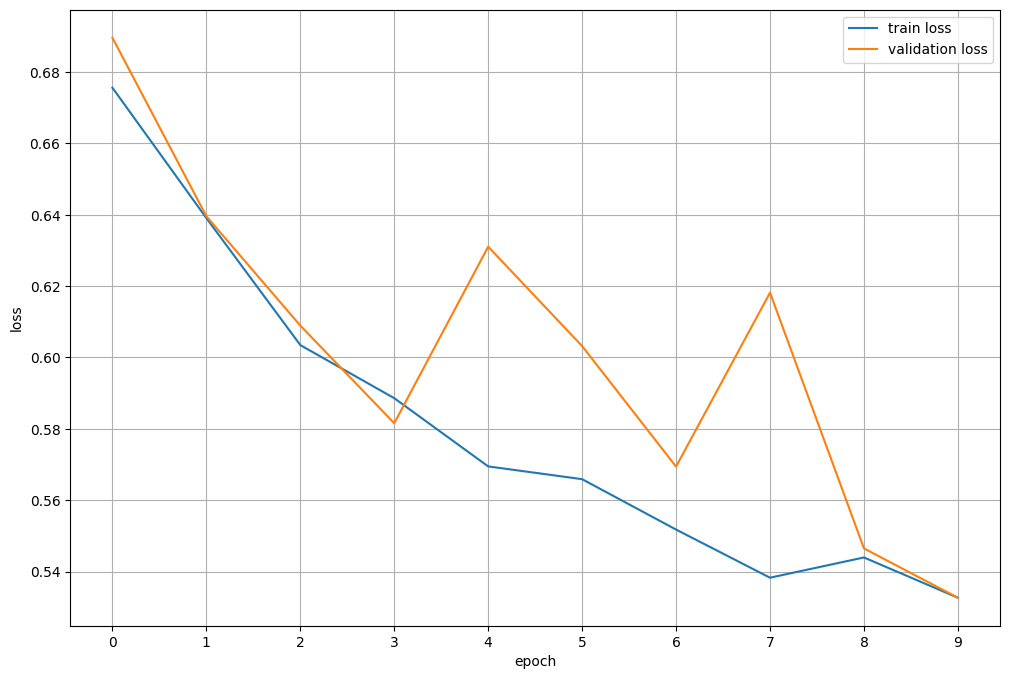

In [28]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["validation_losses"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

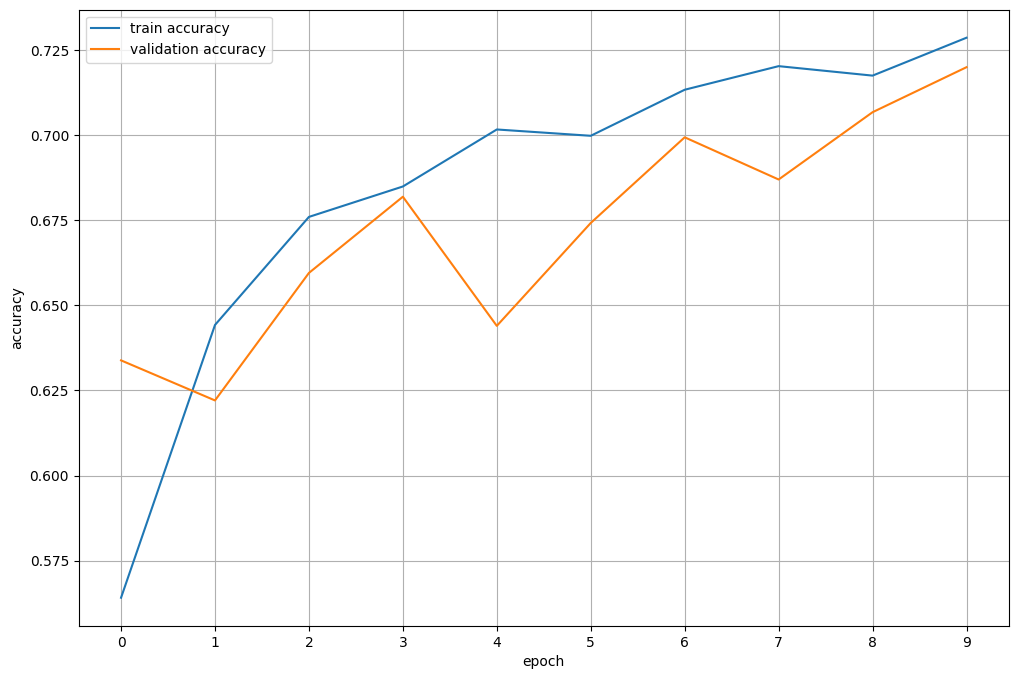

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["validation_accs"], label="validation accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [30]:
model_glove.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = run(test_dataloader, model_glove, criterion, optimizer_glove, device, embedding="glove_embeddings", is_eval=True)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

EVALUATING MODEL...:   0%|          | 0/49 [00:00<?, ?it/s]

EVALUATING MODEL...:   2%|▏         | 1/49 [00:05<04:23,  5.48s/it]

EVALUATING MODEL...:   4%|▍         | 2/49 [00:09<03:47,  4.84s/it]

EVALUATING MODEL...:   6%|▌         | 3/49 [00:15<03:51,  5.04s/it]

EVALUATING MODEL...:   8%|▊         | 4/49 [00:20<03:55,  5.23s/it]

EVALUATING MODEL...:  10%|█         | 5/49 [00:24<03:31,  4.82s/it]

EVALUATING MODEL...:  12%|█▏        | 6/49 [00:28<03:15,  4.56s/it]

EVALUATING MODEL...:  14%|█▍        | 7/49 [00:33<03:13,  4.60s/it]

EVALUATING MODEL...:  16%|█▋        | 8/49 [00:37<03:03,  4.47s/it]

EVALUATING MODEL...:  18%|█▊        | 9/49 [00:42<02:58,  4.47s/it]

EVALUATING MODEL...:  20%|██        | 10/49 [00:46<02:57,  4.55s/it]

EVALUATING MODEL...:  22%|██▏       | 11/49 [00:51<02:50,  4.49s/it]

EVALUATING MODEL...:  24%|██▍       | 12/49 [00:55<02:43,  4.42s/it]

EVALUATING MODEL...:  27%|██▋       | 13/49 [01:00<02:46,  4.62s/it]

EVALUATING MODEL...:  29%|██▊       | 14/49 [01:04<02:37,  4.51s/it]

EVALUATING MODEL...:  31%|███       | 15/49 [01:10<02:41,  4.74s/it]

EVALUATING MODEL...:  33%|███▎      | 16/49 [01:15<02:39,  4.84s/it]

EVALUATING MODEL...:  35%|███▍      | 17/49 [01:19<02:33,  4.80s/it]

EVALUATING MODEL...:  37%|███▋      | 18/49 [01:24<02:25,  4.68s/it]

EVALUATING MODEL...:  39%|███▉      | 19/49 [01:28<02:18,  4.62s/it]

EVALUATING MODEL...:  41%|████      | 20/49 [01:33<02:10,  4.50s/it]

EVALUATING MODEL...:  43%|████▎     | 21/49 [01:37<02:09,  4.61s/it]

EVALUATING MODEL...:  45%|████▍     | 22/49 [01:42<02:04,  4.60s/it]

EVALUATING MODEL...:  47%|████▋     | 23/49 [01:46<01:57,  4.52s/it]

EVALUATING MODEL...:  49%|████▉     | 24/49 [01:51<01:57,  4.69s/it]

EVALUATING MODEL...:  51%|█████     | 25/49 [01:56<01:50,  4.62s/it]

EVALUATING MODEL...:  53%|█████▎    | 26/49 [02:02<01:55,  5.02s/it]

EVALUATING MODEL...:  55%|█████▌    | 27/49 [02:06<01:44,  4.73s/it]

EVALUATING MODEL...:  57%|█████▋    | 28/49 [02:10<01:38,  4.69s/it]

EVALUATING MODEL...:  59%|█████▉    | 29/49 [02:15<01:30,  4.51s/it]

EVALUATING MODEL...:  61%|██████    | 30/49 [02:19<01:25,  4.50s/it]

EVALUATING MODEL...:  63%|██████▎   | 31/49 [02:23<01:20,  4.45s/it]

EVALUATING MODEL...:  65%|██████▌   | 32/49 [02:28<01:14,  4.38s/it]

EVALUATING MODEL...:  67%|██████▋   | 33/49 [02:33<01:13,  4.62s/it]

EVALUATING MODEL...:  69%|██████▉   | 34/49 [02:37<01:08,  4.56s/it]

EVALUATING MODEL...:  71%|███████▏  | 35/49 [02:42<01:03,  4.51s/it]

EVALUATING MODEL...:  73%|███████▎  | 36/49 [02:46<00:56,  4.38s/it]

EVALUATING MODEL...:  76%|███████▌  | 37/49 [02:50<00:52,  4.34s/it]

EVALUATING MODEL...:  78%|███████▊  | 38/49 [02:54<00:48,  4.37s/it]

EVALUATING MODEL...:  80%|███████▉  | 39/49 [02:58<00:42,  4.27s/it]

EVALUATING MODEL...:  82%|████████▏ | 40/49 [03:02<00:37,  4.14s/it]

EVALUATING MODEL...:  84%|████████▎ | 41/49 [03:06<00:33,  4.16s/it]

EVALUATING MODEL...:  86%|████████▌ | 42/49 [03:11<00:29,  4.16s/it]

EVALUATING MODEL...:  88%|████████▊ | 43/49 [03:15<00:26,  4.35s/it]

EVALUATING MODEL...:  90%|████████▉ | 44/49 [03:20<00:21,  4.39s/it]

EVALUATING MODEL...:  92%|█████████▏| 45/49 [03:26<00:19,  4.88s/it]

EVALUATING MODEL...:  94%|█████████▍| 46/49 [03:30<00:13,  4.57s/it]

EVALUATING MODEL...:  96%|█████████▌| 47/49 [03:35<00:09,  4.66s/it]

EVALUATING MODEL...:  98%|█████████▊| 48/49 [03:39<00:04,  4.53s/it]

EVALUATING MODEL...: 100%|██████████| 49/49 [03:45<00:00,  5.08s/it]

EVALUATING MODEL...: 100%|██████████| 49/49 [03:45<00:00,  4.60s/it]

test_loss: 0.539, test_acc: 0.721


In [33]:
n_epochs = 10
best_validation_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = run(
        train_dataloader, model_bert, criterion, optimizer_bert, device, embedding="bert_embeddings"
    )
    validation_loss, validation_acc = run(validation_dataloader, model_bert, criterion, optimizer_bert, device, embedding="bert_embeddings", is_eval=True)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["validation_losses"].append(validation_loss)
    metrics["validation_accs"].append(validation_acc)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model_bert.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"validation_loss: {validation_loss:.3f}, validation_acc: {validation_acc:.3f}")

TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:12<07:50, 12.07s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:24<07:56, 12.53s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:34<06:57, 11.29s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:46<06:53, 11.49s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:58<06:42, 11.51s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:08<06:17, 11.10s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:19<06:04, 11.04s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:30<05:53, 11.06s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:40<05:34, 10.80s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:52<05:32, 11.08s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:03<05:22, 11.10s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:16<05:31, 11.83s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:27<05:07, 11.39s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:41<05:20, 12.33s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:52<04:58, 11.93s/it]

TRAINING MODEL...:  40%|████      | 16/40 [03:03<04:34, 11.43s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:13<04:14, 11.08s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:22<03:53, 10.62s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:33<03:40, 10.50s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:44<03:37, 10.87s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:55<03:27, 10.90s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [04:06<03:15, 10.84s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:17<03:04, 10.86s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:29<02:56, 11.06s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:39<02:42, 10.83s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:49<02:29, 10.65s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [05:00<02:18, 10.69s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:11<02:10, 10.90s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:22<01:57, 10.72s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:32<01:46, 10.68s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:47<01:48, 12.09s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:58<01:32, 11.56s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [06:08<01:18, 11.19s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:18<01:04, 10.81s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:29<00:53, 10.74s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:39<00:42, 10.73s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:49<00:31, 10.51s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [07:01<00:21, 10.90s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:12<00:10, 10.90s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:13<00:00,  7.84s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:13<00:00, 10.83s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.83s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:34,  4.35s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:31,  4.48s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.36s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.14s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.21s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.26s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.86s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.87s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.57s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]

epoch: 0
train_loss: 0.603, train_acc: 0.661
validation_loss: 0.533, validation_acc: 0.720


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:14<09:22, 14.43s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:25<07:54, 12.49s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:35<06:57, 11.29s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:45<06:27, 10.75s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:56<06:15, 10.73s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:06<05:58, 10.55s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:16<05:44, 10.43s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:26<05:25, 10.17s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:36<05:20, 10.33s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:48<05:20, 10.69s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [01:57<05:00, 10.36s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:07<04:47, 10.28s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:17<04:29,  9.99s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:28<04:31, 10.44s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:38<04:12, 10.11s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:47<04:01, 10.05s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [02:57<03:48,  9.92s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:11<04:03, 11.08s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:21<03:46, 10.81s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:31<03:33, 10.66s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:42<03:22, 10.68s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [03:54<03:18, 11.02s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:03<02:59, 10.58s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:14<02:48, 10.55s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:26<02:43, 10.90s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:36<02:31, 10.80s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:47<02:20, 10.80s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [04:58<02:09, 10.78s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:12<02:09, 11.81s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:22<01:52, 11.22s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:31<01:36, 10.71s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:41<01:22, 10.37s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [05:50<01:10, 10.12s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:00<01:00, 10.03s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:11<00:51, 10.26s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:21<00:40, 10.05s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:31<00:30, 10.25s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:41<00:20, 10.02s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [06:51<00:09,  9.92s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:51<00:00,  7.14s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:51<00:00, 10.29s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:47,  5.30s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.53s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:31,  4.45s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.34s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.17s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.12s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.04s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.72s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.89s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.47s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]

epoch: 1
train_loss: 0.527, train_acc: 0.733
validation_loss: 0.519, validation_acc: 0.734


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:10<06:39, 10.23s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:24<07:56, 12.55s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:38<08:06, 13.15s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:48<07:09, 11.93s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [01:00<06:54, 11.84s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:10<06:26, 11.36s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:19<05:54, 10.76s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:31<05:50, 10.96s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:40<05:24, 10.48s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:51<05:19, 10.65s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:02<05:06, 10.58s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:12<04:51, 10.43s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:22<04:40, 10.39s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:32<04:25, 10.22s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:41<04:10, 10.02s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:52<04:03, 10.16s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:02<03:51, 10.05s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:13<03:46, 10.29s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:22<03:33, 10.16s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:32<03:19,  9.98s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:42<03:10, 10.05s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [03:53<03:02, 10.16s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:04<02:58, 10.50s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:15<02:52, 10.77s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:27<02:47, 11.14s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:37<02:27, 10.56s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:47<02:17, 10.55s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:01<02:19, 11.66s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:13<02:07, 11.56s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:23<01:52, 11.26s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:33<01:38, 10.89s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:44<01:25, 10.70s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [05:55<01:17, 11.01s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:07<01:06, 11.08s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:18<00:55, 11.16s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:28<00:42, 10.74s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:38<00:31, 10.51s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:47<00:20, 10.18s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [06:56<00:09,  9.95s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:57<00:00,  7.18s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:57<00:00, 10.44s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:46,  5.20s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.47s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.31s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.28s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.10s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.20s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.08s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.73s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.89s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.49s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]

epoch: 2
train_loss: 0.508, train_acc: 0.746
validation_loss: 0.498, validation_acc: 0.751


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:10<06:39, 10.25s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:20<06:39, 10.50s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:31<06:36, 10.71s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:42<06:26, 10.74s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:52<06:01, 10.34s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:01<05:39,  9.99s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:12<05:36, 10.19s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:23<05:34, 10.44s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:33<05:19, 10.29s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:42<05:02, 10.08s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [01:53<05:01, 10.41s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:05<05:05, 10.90s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:17<04:56, 10.97s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:27<04:44, 10.95s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:38<04:28, 10.75s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:52<04:42, 11.77s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:04<04:33, 11.88s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:14<04:09, 11.35s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:25<03:57, 11.30s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:35<03:37, 10.87s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:45<03:20, 10.53s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [03:54<03:02, 10.16s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:06<03:01, 10.70s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:16<02:47, 10.48s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:27<02:37, 10.47s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:37<02:24, 10.33s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:52<02:32, 11.73s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:02<02:17, 11.42s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:12<02:00, 10.99s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:26<01:57, 11.78s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:37<01:44, 11.62s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:48<01:31, 11.48s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [05:58<01:17, 11.04s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:09<01:06, 11.04s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:20<00:54, 10.91s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:31<00:44, 11.07s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:41<00:32, 10.68s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:51<00:20, 10.28s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:01<00:10, 10.30s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00,  7.43s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00, 10.55s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:48,  5.38s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.56s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.36s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.35s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.14s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.21s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.10s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.76s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.91s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.49s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]

epoch: 3
train_loss: 0.479, train_acc: 0.765
validation_loss: 0.589, validation_acc: 0.707


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:11<07:13, 11.11s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:20<06:34, 10.39s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:30<06:15, 10.15s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:42<06:26, 10.72s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:52<06:04, 10.42s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:03<05:57, 10.50s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:17<06:26, 11.70s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:29<06:21, 11.92s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:40<06:01, 11.67s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:50<05:37, 11.23s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:02<05:24, 11.20s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:12<05:10, 11.10s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:28<05:32, 12.32s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:41<05:30, 12.70s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:51<04:57, 11.88s/it]

TRAINING MODEL...:  40%|████      | 16/40 [03:02<04:37, 11.57s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:12<04:15, 11.11s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:23<04:03, 11.08s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:34<03:50, 10.99s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:44<03:34, 10.74s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:53<03:16, 10.32s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [04:04<03:08, 10.49s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:14<02:55, 10.31s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:25<02:49, 10.60s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:36<02:38, 10.55s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:45<02:23, 10.27s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:56<02:16, 10.50s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:06<02:03, 10.32s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:18<01:56, 10.57s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:28<01:45, 10.52s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:39<01:36, 10.72s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:51<01:28, 11.07s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [06:01<01:15, 10.79s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:12<01:05, 10.86s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:24<00:56, 11.24s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:35<00:43, 10.95s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:45<00:32, 10.84s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:55<00:20, 10.40s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:06<00:10, 10.72s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:07<00:00,  7.73s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:07<00:00, 10.68s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:46,  5.18s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.59s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:31,  4.45s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.34s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:25,  5.15s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.20s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.08s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.75s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:44<00:05,  5.00s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.60s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]

epoch: 4
train_loss: 0.480, train_acc: 0.766
validation_loss: 0.482, validation_acc: 0.760


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:09<05:55,  9.11s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:19<06:16,  9.91s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:31<06:35, 10.68s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:42<06:37, 11.04s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:52<06:15, 10.74s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:07<06:47, 11.98s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:17<06:11, 11.27s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:31<06:36, 12.38s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:42<06:01, 11.66s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:52<05:43, 11.45s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:06<05:49, 12.05s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:17<05:27, 11.70s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:26<04:59, 11.10s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:38<04:48, 11.09s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:49<04:42, 11.30s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:59<04:22, 10.95s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:11<04:16, 11.16s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:22<04:02, 11.04s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:32<03:43, 10.65s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:41<03:27, 10.37s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:51<03:14, 10.23s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [04:03<03:11, 10.66s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:14<03:01, 10.68s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:24<02:50, 10.65s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:34<02:37, 10.48s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:46<02:31, 10.79s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:58<02:24, 11.12s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:08<02:11, 10.93s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:18<01:57, 10.66s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:29<01:45, 10.57s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:39<01:33, 10.38s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:50<01:26, 10.77s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [06:00<01:13, 10.48s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:11<01:03, 10.52s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:20<00:50, 10.19s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:30<00:40, 10.08s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:40<00:30, 10.16s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:52<00:21, 10.54s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:02<00:10, 10.36s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00,  7.46s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00, 10.57s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.84s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.49s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.32s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.30s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:24,  5.00s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.19s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.11s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.76s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.81s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.42s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]

epoch: 5
train_loss: 0.445, train_acc: 0.788
validation_loss: 0.511, validation_acc: 0.738


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:14<09:13, 14.20s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:24<07:25, 11.73s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:33<06:31, 10.58s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:43<06:14, 10.40s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:58<06:59, 11.99s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:09<06:38, 11.73s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:19<06:03, 11.03s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:30<05:53, 11.04s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:39<05:28, 10.59s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:51<05:23, 10.78s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:00<05:03, 10.47s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:10<04:46, 10.25s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:20<04:34, 10.16s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:31<04:31, 10.46s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:42<04:20, 10.44s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:52<04:13, 10.55s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:02<03:54, 10.19s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:13<03:51, 10.53s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:23<03:35, 10.24s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:35<03:35, 10.79s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:45<03:21, 10.61s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [03:55<03:07, 10.39s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:06<03:02, 10.76s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:17<02:53, 10.86s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:28<02:40, 10.72s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:39<02:32, 10.87s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:50<02:21, 10.89s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:01<02:11, 10.94s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:12<02:01, 11.08s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:23<01:48, 10.86s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:35<01:41, 11.23s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:44<01:25, 10.65s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [05:56<01:16, 10.92s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:06<01:03, 10.60s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:15<00:51, 10.27s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:25<00:40, 10.06s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:35<00:30, 10.24s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:46<00:20, 10.47s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [06:56<00:10, 10.23s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:57<00:00,  7.39s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [06:57<00:00, 10.43s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.86s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:08<00:35,  4.39s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:31,  4.47s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.34s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.02s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.10s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:33<00:15,  5.02s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.73s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:42<00:04,  4.78s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.51s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

epoch: 6
train_loss: 0.440, train_acc: 0.790
validation_loss: 0.478, validation_acc: 0.772


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:09<06:03,  9.31s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:20<06:28, 10.22s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:29<06:09,  9.98s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:40<06:04, 10.12s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:51<06:03, 10.37s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:01<05:57, 10.53s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:12<05:53, 10.73s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:22<05:33, 10.43s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:32<05:18, 10.26s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:44<05:20, 10.68s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [01:53<04:59, 10.33s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:04<04:48, 10.31s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:13<04:34, 10.17s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:23<04:18,  9.93s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:33<04:13, 10.15s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:44<04:05, 10.23s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [02:54<03:57, 10.35s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:08<04:08, 11.28s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:19<03:53, 11.10s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:29<03:35, 10.78s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:40<03:27, 10.91s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [03:54<03:33, 11.84s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:06<03:20, 11.78s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:16<03:00, 11.27s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:30<03:03, 12.21s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:41<02:46, 11.87s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:51<02:27, 11.37s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:02<02:14, 11.22s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:13<02:03, 11.18s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:24<01:51, 11.16s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:34<01:36, 10.72s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:44<01:24, 10.56s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [05:56<01:16, 10.87s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:08<01:06, 11.13s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:18<00:54, 10.95s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:28<00:42, 10.58s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:38<00:31, 10.45s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:49<00:21, 10.71s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:01<00:10, 10.95s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00,  7.89s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:02<00:00, 10.55s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:04<00:43,  4.81s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:36,  4.51s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.32s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:25,  4.25s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:24,  4.97s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:20,  5.12s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.14s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.77s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.87s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.53s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]

epoch: 7
train_loss: 0.415, train_acc: 0.804
validation_loss: 0.473, validation_acc: 0.768


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:14<09:11, 14.15s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:25<07:48, 12.34s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:35<07:08, 11.59s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:46<06:48, 11.35s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:57<06:22, 10.92s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:11<06:55, 12.23s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:21<06:17, 11.44s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:32<06:04, 11.38s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:43<05:43, 11.07s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:54<05:32, 11.07s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:05<05:20, 11.04s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:14<04:55, 10.56s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:26<04:53, 10.88s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:36<04:35, 10.58s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:47<04:26, 10.65s/it]

TRAINING MODEL...:  40%|████      | 16/40 [02:58<04:23, 10.99s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:09<04:12, 10.96s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:19<03:52, 10.57s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:30<03:45, 10.75s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:40<03:28, 10.43s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [03:50<03:16, 10.34s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [04:01<03:09, 10.52s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:11<02:57, 10.43s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:21<02:44, 10.27s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:33<02:39, 10.64s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:43<02:30, 10.73s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [04:55<02:23, 11.01s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:05<02:08, 10.72s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:15<01:56, 10.57s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:26<01:45, 10.58s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:36<01:33, 10.41s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:46<01:22, 10.30s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [06:00<01:19, 11.41s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:11<01:07, 11.29s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:21<00:54, 10.95s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:32<00:44, 11.00s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:42<00:32, 10.72s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [06:53<00:21, 10.69s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:03<00:10, 10.50s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:04<00:00,  7.55s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:04<00:00, 10.61s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:45,  5.02s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.42s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:29,  4.27s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:17<00:26,  4.35s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:23<00:25,  5.05s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:28<00:20,  5.03s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:34<00:15,  5.08s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:38<00:09,  4.82s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:43<00:04,  4.91s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.55s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]

epoch: 8
train_loss: 0.384, train_acc: 0.822
validation_loss: 0.495, validation_acc: 0.762


TRAINING MODEL...:   0%|          | 0/40 [00:00<?, ?it/s]

TRAINING MODEL...:   2%|▎         | 1/40 [00:11<07:23, 11.36s/it]

TRAINING MODEL...:   5%|▌         | 2/40 [00:23<07:38, 12.06s/it]

TRAINING MODEL...:   8%|▊         | 3/40 [00:35<07:18, 11.86s/it]

TRAINING MODEL...:  10%|█         | 4/40 [00:47<07:10, 11.96s/it]

TRAINING MODEL...:  12%|█▎        | 5/40 [00:59<07:02, 12.07s/it]

TRAINING MODEL...:  15%|█▌        | 6/40 [01:12<06:51, 12.09s/it]

TRAINING MODEL...:  18%|█▊        | 7/40 [01:23<06:30, 11.84s/it]

TRAINING MODEL...:  20%|██        | 8/40 [01:34<06:16, 11.76s/it]

TRAINING MODEL...:  22%|██▎       | 9/40 [01:46<06:02, 11.70s/it]

TRAINING MODEL...:  25%|██▌       | 10/40 [01:56<05:36, 11.23s/it]

TRAINING MODEL...:  28%|██▊       | 11/40 [02:07<05:19, 11.00s/it]

TRAINING MODEL...:  30%|███       | 12/40 [02:22<05:46, 12.39s/it]

TRAINING MODEL...:  32%|███▎      | 13/40 [02:37<05:53, 13.09s/it]

TRAINING MODEL...:  35%|███▌      | 14/40 [02:47<05:19, 12.30s/it]

TRAINING MODEL...:  38%|███▊      | 15/40 [02:58<04:56, 11.86s/it]

TRAINING MODEL...:  40%|████      | 16/40 [03:09<04:36, 11.51s/it]

TRAINING MODEL...:  42%|████▎     | 17/40 [03:19<04:15, 11.10s/it]

TRAINING MODEL...:  45%|████▌     | 18/40 [03:29<03:54, 10.67s/it]

TRAINING MODEL...:  48%|████▊     | 19/40 [03:43<04:05, 11.68s/it]

TRAINING MODEL...:  50%|█████     | 20/40 [03:53<03:43, 11.17s/it]

TRAINING MODEL...:  52%|█████▎    | 21/40 [04:02<03:23, 10.73s/it]

TRAINING MODEL...:  55%|█████▌    | 22/40 [04:14<03:19, 11.09s/it]

TRAINING MODEL...:  57%|█████▊    | 23/40 [04:25<03:06, 10.98s/it]

TRAINING MODEL...:  60%|██████    | 24/40 [04:36<02:55, 10.95s/it]

TRAINING MODEL...:  62%|██████▎   | 25/40 [04:47<02:44, 10.97s/it]

TRAINING MODEL...:  65%|██████▌   | 26/40 [04:57<02:28, 10.63s/it]

TRAINING MODEL...:  68%|██████▊   | 27/40 [05:07<02:15, 10.43s/it]

TRAINING MODEL...:  70%|███████   | 28/40 [05:17<02:03, 10.30s/it]

TRAINING MODEL...:  72%|███████▎  | 29/40 [05:27<01:53, 10.28s/it]

TRAINING MODEL...:  75%|███████▌  | 30/40 [05:38<01:44, 10.50s/it]

TRAINING MODEL...:  78%|███████▊  | 31/40 [05:48<01:32, 10.33s/it]

TRAINING MODEL...:  80%|████████  | 32/40 [05:59<01:24, 10.54s/it]

TRAINING MODEL...:  82%|████████▎ | 33/40 [06:09<01:13, 10.45s/it]

TRAINING MODEL...:  85%|████████▌ | 34/40 [06:20<01:02, 10.45s/it]

TRAINING MODEL...:  88%|████████▊ | 35/40 [06:32<00:54, 10.89s/it]

TRAINING MODEL...:  90%|█████████ | 36/40 [06:42<00:43, 10.84s/it]

TRAINING MODEL...:  92%|█████████▎| 37/40 [06:52<00:31, 10.44s/it]

TRAINING MODEL...:  95%|█████████▌| 38/40 [07:03<00:21, 10.62s/it]

TRAINING MODEL...:  98%|█████████▊| 39/40 [07:14<00:10, 10.85s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:15<00:00,  7.80s/it]

TRAINING MODEL...: 100%|██████████| 40/40 [07:15<00:00, 10.89s/it]

EVALUATING MODEL...:   0%|          | 0/10 [00:00<?, ?it/s]

EVALUATING MODEL...:  10%|█         | 1/10 [00:05<00:46,  5.12s/it]

EVALUATING MODEL...:  20%|██        | 2/10 [00:09<00:35,  4.46s/it]

EVALUATING MODEL...:  30%|███       | 3/10 [00:13<00:30,  4.32s/it]

EVALUATING MODEL...:  40%|████      | 4/10 [00:18<00:27,  4.57s/it]

EVALUATING MODEL...:  50%|█████     | 5/10 [00:24<00:26,  5.21s/it]

EVALUATING MODEL...:  60%|██████    | 6/10 [00:29<00:21,  5.25s/it]

EVALUATING MODEL...:  70%|███████   | 7/10 [00:35<00:15,  5.24s/it]

EVALUATING MODEL...:  80%|████████  | 8/10 [00:39<00:09,  4.87s/it]

EVALUATING MODEL...:  90%|█████████ | 9/10 [00:44<00:04,  4.91s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.52s/it]

EVALUATING MODEL...: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]

epoch: 9
train_loss: 0.350, train_acc: 0.844
validation_loss: 0.498, validation_acc: 0.763


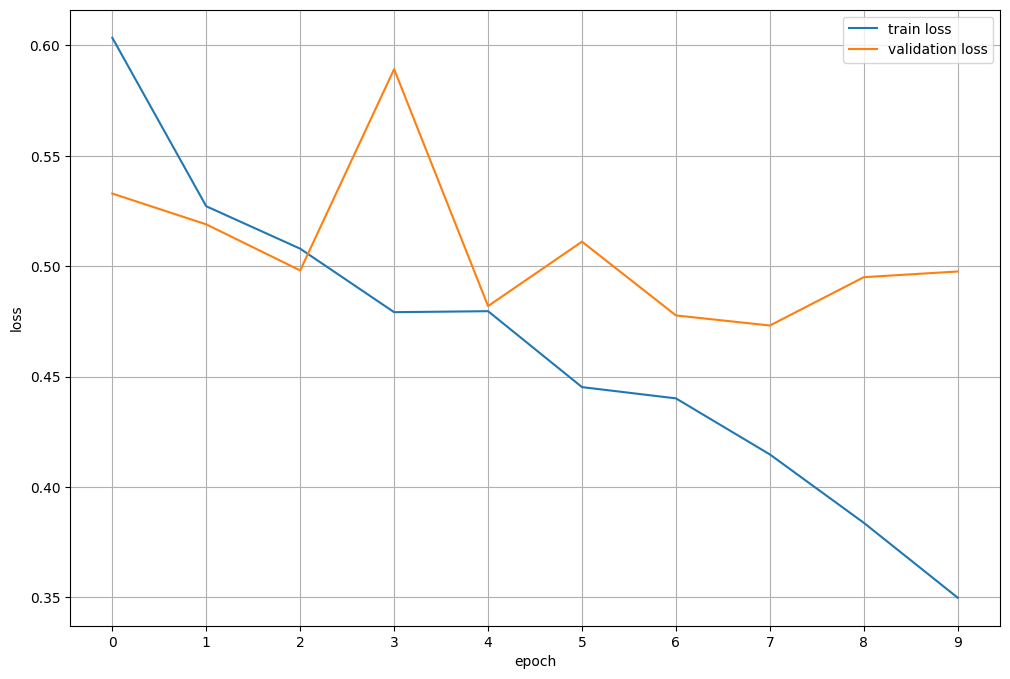

In [34]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["validation_losses"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

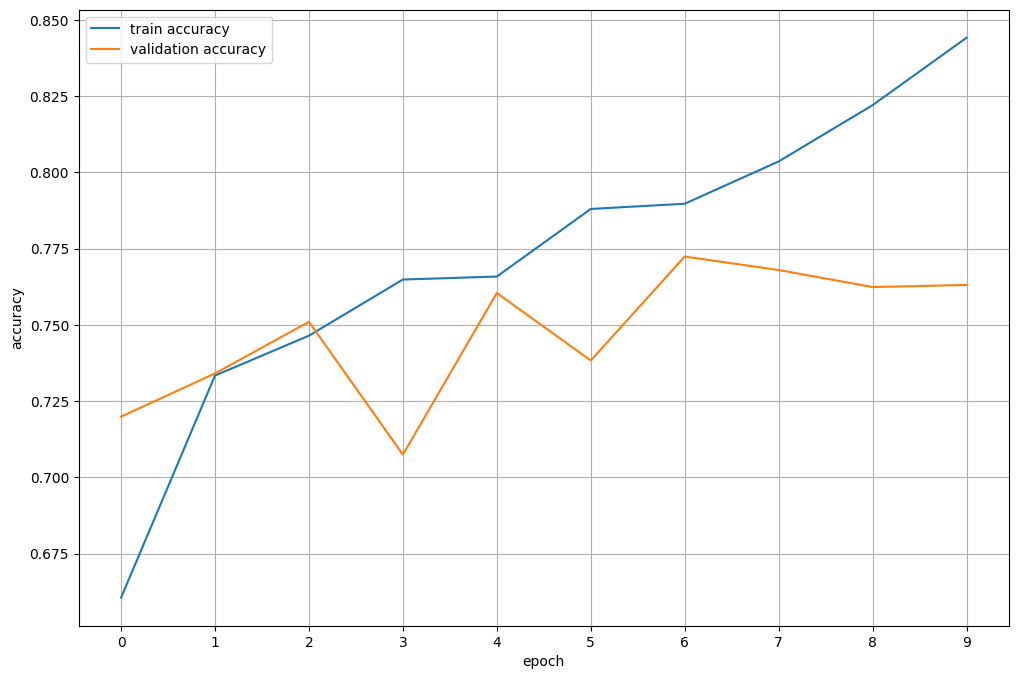

In [35]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["validation_accs"], label="validation accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [36]:
model_bert.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = run(test_dataloader, model_bert, criterion, optimizer_bert, device, embedding="bert_embeddings", is_eval=True)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

EVALUATING MODEL...:   0%|          | 0/49 [00:00<?, ?it/s]

EVALUATING MODEL...:   2%|▏         | 1/49 [00:05<04:38,  5.81s/it]

EVALUATING MODEL...:   4%|▍         | 2/49 [00:10<03:56,  5.02s/it]

EVALUATING MODEL...:   6%|▌         | 3/49 [00:15<03:49,  5.00s/it]

EVALUATING MODEL...:   8%|▊         | 4/49 [00:20<03:55,  5.24s/it]

EVALUATING MODEL...:  10%|█         | 5/49 [00:25<03:38,  4.97s/it]

EVALUATING MODEL...:  12%|█▏        | 6/49 [00:29<03:20,  4.67s/it]

EVALUATING MODEL...:  14%|█▍        | 7/49 [00:33<03:14,  4.63s/it]

EVALUATING MODEL...:  16%|█▋        | 8/49 [00:38<03:04,  4.50s/it]

EVALUATING MODEL...:  18%|█▊        | 9/49 [00:42<02:59,  4.50s/it]

EVALUATING MODEL...:  20%|██        | 10/49 [00:48<03:06,  4.78s/it]

EVALUATING MODEL...:  22%|██▏       | 11/49 [00:52<02:53,  4.56s/it]

EVALUATING MODEL...:  24%|██▍       | 12/49 [00:56<02:49,  4.58s/it]

EVALUATING MODEL...:  27%|██▋       | 13/49 [01:01<02:50,  4.75s/it]

EVALUATING MODEL...:  29%|██▊       | 14/49 [01:06<02:44,  4.70s/it]

EVALUATING MODEL...:  31%|███       | 15/49 [01:11<02:42,  4.77s/it]

EVALUATING MODEL...:  33%|███▎      | 16/49 [01:16<02:38,  4.80s/it]

EVALUATING MODEL...:  35%|███▍      | 17/49 [01:20<02:31,  4.72s/it]

EVALUATING MODEL...:  37%|███▋      | 18/49 [01:25<02:24,  4.68s/it]

EVALUATING MODEL...:  39%|███▉      | 19/49 [01:29<02:16,  4.56s/it]

EVALUATING MODEL...:  41%|████      | 20/49 [01:33<02:09,  4.47s/it]

EVALUATING MODEL...:  43%|████▎     | 21/49 [01:39<02:12,  4.72s/it]

EVALUATING MODEL...:  45%|████▍     | 22/49 [01:44<02:08,  4.77s/it]

EVALUATING MODEL...:  47%|████▋     | 23/49 [01:48<02:00,  4.64s/it]

EVALUATING MODEL...:  49%|████▉     | 24/49 [01:53<01:58,  4.72s/it]

EVALUATING MODEL...:  51%|█████     | 25/49 [01:58<01:54,  4.77s/it]

EVALUATING MODEL...:  53%|█████▎    | 26/49 [02:04<01:59,  5.18s/it]

EVALUATING MODEL...:  55%|█████▌    | 27/49 [02:08<01:47,  4.87s/it]

EVALUATING MODEL...:  57%|█████▋    | 28/49 [02:13<01:41,  4.81s/it]

EVALUATING MODEL...:  59%|█████▉    | 29/49 [02:17<01:32,  4.61s/it]

EVALUATING MODEL...:  61%|██████    | 30/49 [02:21<01:25,  4.49s/it]

EVALUATING MODEL...:  63%|██████▎   | 31/49 [02:26<01:23,  4.64s/it]

EVALUATING MODEL...:  65%|██████▌   | 32/49 [02:31<01:17,  4.57s/it]

EVALUATING MODEL...:  67%|██████▋   | 33/49 [02:36<01:17,  4.87s/it]

EVALUATING MODEL...:  69%|██████▉   | 34/49 [02:40<01:09,  4.64s/it]

EVALUATING MODEL...:  71%|███████▏  | 35/49 [02:45<01:05,  4.68s/it]

EVALUATING MODEL...:  73%|███████▎  | 36/49 [02:49<00:58,  4.51s/it]

EVALUATING MODEL...:  76%|███████▌  | 37/49 [02:53<00:53,  4.45s/it]

EVALUATING MODEL...:  78%|███████▊  | 38/49 [02:58<00:48,  4.37s/it]

EVALUATING MODEL...:  80%|███████▉  | 39/49 [03:02<00:43,  4.40s/it]

EVALUATING MODEL...:  82%|████████▏ | 40/49 [03:06<00:39,  4.37s/it]

EVALUATING MODEL...:  84%|████████▎ | 41/49 [03:11<00:35,  4.40s/it]

EVALUATING MODEL...:  86%|████████▌ | 42/49 [03:15<00:30,  4.31s/it]

EVALUATING MODEL...:  88%|████████▊ | 43/49 [03:19<00:26,  4.36s/it]

EVALUATING MODEL...:  90%|████████▉ | 44/49 [03:24<00:22,  4.41s/it]

EVALUATING MODEL...:  92%|█████████▏| 45/49 [03:31<00:20,  5.11s/it]

EVALUATING MODEL...:  94%|█████████▍| 46/49 [03:34<00:14,  4.72s/it]

EVALUATING MODEL...:  96%|█████████▌| 47/49 [03:39<00:09,  4.62s/it]

EVALUATING MODEL...:  98%|█████████▊| 48/49 [03:43<00:04,  4.47s/it]

EVALUATING MODEL...: 100%|██████████| 49/49 [03:50<00:00,  5.15s/it]

EVALUATING MODEL...: 100%|██████████| 49/49 [03:50<00:00,  4.70s/it]

test_loss: 0.481, test_acc: 0.765
